# **Food Classification Using VGG-16**

**Note : Before reading this Jupyter Notebook, read the notebook named "1.Inception V3 - Food Classification.ipynb"**

**Dataset:**

  The Dataset is obtained from Kaggle. This contains 11 classes of food images.


**Aim:** 

  The main objective of the project is to build a multi-class image classifier to identify the food category given an image of food.

**Neural Network Architecture used:**

This project experiements to build a model on Inception V3 architecture and VGG16 architecture using transfer learning and select the model that provides best accuracy.

## **Load the Packages:**

In [ ]:
# import the basic libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# import tensorflow and related libraries
from tensorflow import keras
from keras.applications import vgg16 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPool2D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model

# import the metrics package for model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# importing package to display the image
import cv2
from google.colab.patches import cv2_imshow

# import packages to connect to google drive
from google.colab import drive

## **Accessing the Dataset**

In [ ]:
# the dataset is stored in google drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
os.getcwd()

'/content/drive/My Drive/Food-11 image dataset'

In [ ]:
os.chdir("/content/drive/My Drive/Food-11 image dataset/")

Inside the Folder "Food-11 image dataset", There are three folders :

>1) Train

>2) Validate

>3) Test

Each folders contain 11 sub-folder. Each sub-folder contains images of each food catgory.

In [ ]:
# there are 11 categories in Food-11 dataset
target_labels = ["Bread", 
                 "Dairy product", 
                 "Dessert", 
                 "Egg", 
                 "Fried food", 
                 "Meat", 
                 "Noodles-Pasta", 
                 "Rice", 
                 "Seafood", 
                 "Soup", 
                 "Vegetable-Fruit"]

In [ ]:
path = "/content/drive/My Drive/Food-11 image dataset/"

## **Data Augmentation**

For the images in train dataset alone the augmentation is used.

For train, validate and test dataset, the data is preprocessed into required format of VGG 16.

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=vgg16.preprocess_input
        )

validate_datagen = ImageDataGenerator(
                                      preprocessing_function = vgg16.preprocess_input
                                      )
test_datagen = ImageDataGenerator(
                                  preprocessing_function= vgg16.preprocess_input
                                  )

Note:

*   First, Tried with batch size = 64, after running for 5+ hours, the model trained only 4 epochs and got discontinued due to colab gpu being fully utilized.
*   In second attempt, I increased the batch size to 128, this time it ran only 7 epochs and got stopped due to GPU utilization
*   In third attempt, increased the batch size = 256 (it worked out :-))




In [ ]:
BATCH_SIZE = 256

In [ ]:
# flow from directory obtains images from the specified folders in the specified batch size.
# flow_from_directory provides to labels image, based on the name of the folder in which the image is present.
train_generator = train_datagen.flow_from_directory(path+"training",
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes= target_labels,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validate_generator = validate_datagen.flow_from_directory(path+"validation",
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes= target_labels,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

test_generator = test_datagen.flow_from_directory(path+"evaluation",
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes= target_labels,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             seed=42)

Found 9894 images belonging to 11 classes.
Found 3435 images belonging to 11 classes.
Found 3360 images belonging to 11 classes.


# **VGG-16 Model**

In [ ]:
# the VGG16 is loaded as base model and neural network layers are added
base_model = vgg16.VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (224, 224, 3)
)
base_model.trainable = False

# inputs = keras.layers.Input(shape=(224, 224, 3))
head_model = base_model.output 
head_model = Flatten()(head_model)
head_model = BatchNormalization()(head_model)
head_model = Dense(516, activation = 'relu')(head_model)
head_model = Dropout(0.3) (head_model)
head_model = BatchNormalization()(head_model)

head_model = Dense(156, activation = 'relu')(head_model)
head_model = Dropout(0.3) (head_model)
head_model = BatchNormalization()(head_model)

head_model = Dense(11, activation = 'softmax', name = "output")(head_model)
head_model = (head_model)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model = Model(inputs = base_model.input, outputs = head_model)

# the loss, optimzer and metric for evaluation are set
model.compile(loss = "categorical_crossentropy",
             optimizer = "adam",
             metrics = "accuracy")


# the ModelCheckpoint mentioned here will save the model in specified file_path after each epoch completed if the "val-accuracy" has increased.
filepath="/content/drive/My Drive/Food-11 image dataset/MODEL_VGG-16-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
# if the accuracy of validation set is not increasing by atleast by 1% in 5 epochs the training will be stopped.
earlystopping = EarlyStopping(
    monitor = 'val_accuracy', 
    min_delta = 0.01,
    patience = 5,
    restore_best_weights = True,
)

This notebook is being trained in google colab, if more than 20 epochs are being run in colab then there are chances that allocated GPU is utilized and can get terminated.

So the model will the trained for 20 epochs, if the model is still improving then we can add another 20 epochs and continue training.

In [ ]:
vgg_history = model.fit(
    train_generator, 
    batch_size=BATCH_SIZE,
    steps_per_epoch = train_generator.n // train_generator.batch_size, 
    epochs = 20,  
    validation_data = validate_generator,
    validation_steps = validate_generator.n // validate_generator.batch_size,
    callbacks = [checkpoint, earlystopping],
    verbose=1
)

Epoch 1/20
38/38 [==============================] - 8198s 215s/step - loss: 1.2178 - accuracy: 0.6161 - val_loss: 1.4783 - val_accuracy: 0.7761

Epoch 00001: val_accuracy improved from -inf to 0.77614, saving model to /content/drive/My Drive/Food-11 image dataset/MODEL_VGG-16-01-0.78.hdf5
Epoch 2/20
38/38 [==============================] - 220s 6s/step - loss: 0.7647 - accuracy: 0.7530 - val_loss: 0.8767 - val_accuracy: 0.8035

Epoch 00002: val_accuracy improved from 0.77614 to 0.80349, saving model to /content/drive/My Drive/Food-11 image dataset/MODEL_VGG-16-02-0.80.hdf5
Epoch 3/20
38/38 [==============================] - 217s 6s/step - loss: 0.6441 - accuracy: 0.7853 - val_loss: 0.6971 - val_accuracy: 0.8182

Epoch 00003: val_accuracy improved from 0.80349 to 0.81821, saving model to /content/drive/My Drive/Food-11 image dataset/MODEL_VGG-16-03-0.82.hdf5
Epoch 4/20
38/38 [==============================] - 218s 6s/step - loss: 0.5738 - accuracy: 0.8121 - val_loss: 0.6106 - val_accura

In [ ]:
vgg_history_frame = pd.DataFrame(vgg_history.history)

In [ ]:
vgg_history_frame.to_csv("vgg_model_history_1.csv")
!cp vgg_model_history_1.csv path

cp: cannot stat 'vgg_history_1.csv': No such file or directory


In [ ]:
vgg_hist = pd.read_csv("vgg_model_history_1.csv")
vgg_hist.index = np.arange(1,13)
vgg_hist.head(2)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
1,0,1.2178,0.6161,1.4783,0.7761
2,0,0.7647,0.7530,0.8767,0.8035


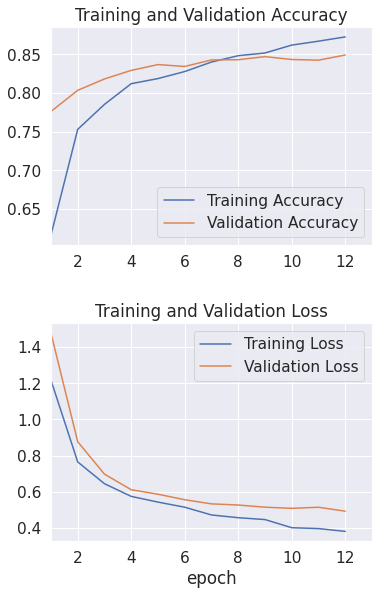

In [ ]:
plt.figure(figsize=(6, 9))
plt.subplot(2, 1, 1)
plt.plot(vgg_hist['accuracy'], label='Training Accuracy')
plt.plot(vgg_hist['val_accuracy'], label='Validation Accuracy')
plt.xlim(1, 13)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_hist['loss'], label='Training Loss')
plt.plot(vgg_hist['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(1, 13)
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.tight_layout(pad=2.0)
plt.show()

## **Evaluation of VGG16 Model**

In [ ]:
vgg_16_model = load_model("MODEL_VGG-16-12-0.85.hdf5")

In generator the "shuffle" parameter when evaluating a model, has to be set "False", so that the predictions from model and true_labels obtained are for the same image.


If the "shuffle" = True, the order of images predicted from data sub set (train/test) changes.

In [ ]:
train_generator_shuffle = train_datagen.flow_from_directory(path+"training",
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes= target_labels,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=False,
                                               seed=42)

validate_generator_shuffle = validate_datagen.flow_from_directory(path+"validation",
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes= target_labels,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=False,
                                               seed=42)

Found 9894 images belonging to 11 classes.
Found 3435 images belonging to 11 classes.


In [ ]:
# a function to evaluate the prediction of dataset from a given model
def model_evaluation(model, generator):
  generator.reset() # There is a reset() method for the datagenerators which resets it to the first batch. So whenever you would want to correlate the model output with the filenames you need to set shuffle as False and reset the datagenerator before performing any prediction. This will ensure that our files are being read properly and there is nothing wrong with them.

  true_classes = generator.classes
  class_indices = dict((v,k) for k,v in generator.class_indices.items())
  preds = model.predict(generator)
  preds_classes = np.argmax(preds, axis=1)
  return [true_classes, preds_classes, generator.class_indices.keys()]

In [ ]:
# for the prediction made, this function prints a confusion matrix 
def plot_confusion_matrix(true_classes, preds_classes, target_names):
  cm = confusion_matrix(true_classes, preds_classes)

  df_cm = pd.DataFrame(cm, columns=target_names, index = target_names)
  plt.figure(figsize=(8,7))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, annot=True, fmt='g', cbar=False, cmap="YlGnBu") # font size , annot_kws={"size": 16}
  plt.title('Confusion Matrix\n', y=1.1)
  plt.ylabel('Actual label\n')
  plt.xlabel('Predicted label\n')

  plt.show()

In [ ]:
result_1 = model_evaluation(vgg_16_model, train_generator_shuffle)
true_classes_1, preds_classes_1, target_names_1 = result_1[0], result_1[1], result_1[2]

In [ ]:
train_acc = accuracy_score(true_classes_1, preds_classes_1) 
print("VGG-16 Model without Fine-Tuning on Training set has Accuracy: {:.2f}%".format(train_acc * 100))

VGG-16 Model without Fine-Tuning on Training set has Accuracy: 90.68%


In [ ]:
result_2 = model_evaluation(vgg_16_model, validate_generator_shuffle)
true_classes_2, preds_classes_2, target_names_2 = result_2[0], result_2[1], result_2[2]

In [ ]:
validate_acc = accuracy_score(true_classes_2, preds_classes_2) 
print("VGG-16 Model without Fine-Tuning on Validation set has Accuracy: {:.2f}%".format(validate_acc * 100))

VGG-16 Model without Fine-Tuning on Validation set has Accuracy: 84.80%


In [ ]:
print("Classification report of Validation set without Fine-Tuning : ")
print(classification_report(true_classes_2, preds_classes_2,target_names =  target_names_2))

Classification report of Validation set without Fine-Tuning : 
                 precision    recall  f1-score   support

          Bread       0.85      0.73      0.79       362
  Dairy product       0.83      0.73      0.78       144
        Dessert       0.79      0.82      0.80       500
            Egg       0.71      0.84      0.77       327
     Fried food       0.83      0.84      0.84       326
           Meat       0.82      0.86      0.84       449
  Noodles-Pasta       0.99      0.96      0.97       147
           Rice       0.91      0.97      0.94        96
        Seafood       0.91      0.81      0.86       347
           Soup       0.93      0.93      0.93       500
Vegetable-Fruit       0.92      0.92      0.92       237

       accuracy                           0.85      3435
      macro avg       0.86      0.86      0.86      3435
   weighted avg       0.85      0.85      0.85      3435



Confusion Matrix of Validation set without Fine-Tuning : 


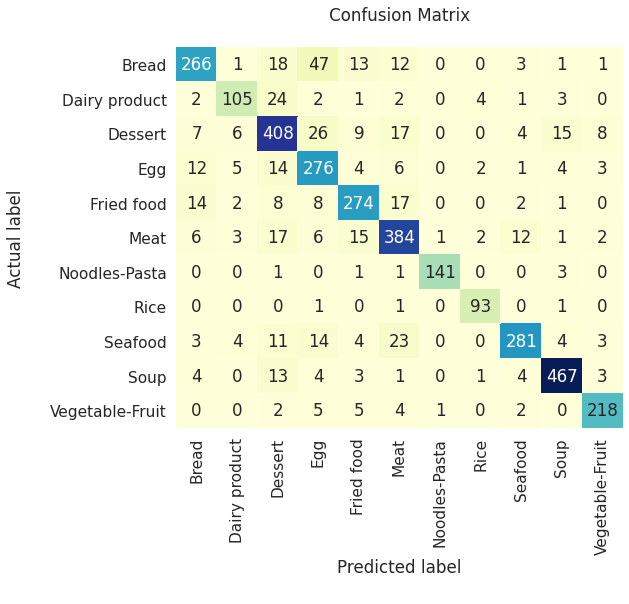

In [ ]:
print("Confusion Matrix of Validation set without Fine-Tuning : ")
plot_confusion_matrix(true_classes_2, preds_classes_2, target_names_2)

# **Fine Tuning**

In [ ]:
# Setting last Convolutional block as trainable for fine tuning.
for layer in base_model.layers[15:]:
  layer.trainable = True

In [ ]:
for idx,layer in enumerate(base_model.layers):
  print(idx,layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7f013ac0dd10> False
1 <keras.layers.convolutional.Conv2D object at 0x7f013ac57b10> False
2 <keras.layers.convolutional.Conv2D object at 0x7f01389e32d0> False
3 <keras.layers.pooling.MaxPooling2D object at 0x7f01389fcb50> False
4 <keras.layers.convolutional.Conv2D object at 0x7f013864a550> False
5 <keras.layers.convolutional.Conv2D object at 0x7f013864d790> False
6 <keras.layers.pooling.MaxPooling2D object at 0x7f0138659b10> False
7 <keras.layers.convolutional.Conv2D object at 0x7f01386622d0> False
8 <keras.layers.convolutional.Conv2D object at 0x7f013865d650> False
9 <keras.layers.convolutional.Conv2D object at 0x7f013b23fed0> False
10 <keras.layers.pooling.MaxPooling2D object at 0x7f01386730d0> False
11 <keras.layers.convolutional.Conv2D object at 0x7f013866e9d0> False
12 <keras.layers.convolutional.Conv2D object at 0x7f0138659a90> False
13 <keras.layers.convolutional.Conv2D object at 0x7f01385fcb10> False
14 <keras.layers.pooling.Max

In [ ]:
opt = keras.optimizers.Adam(1e-5)

vgg_16_model.compile(loss = "categorical_crossentropy",
             optimizer = opt,
             metrics = "accuracy")

# renaming the file path
filepath_ft="/content/drive/My Drive/Food-11 image dataset/Fine_Tune-MODEL_VGG-16-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint_ft = ModelCheckpoint(filepath_ft, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_ft = [checkpoint_ft]

In [ ]:
initial_epoch = 12

In [ ]:
vgg_history_ft = vgg_16_model.fit(
    train_generator, 
    batch_size=BATCH_SIZE,
    steps_per_epoch = train_generator.n // train_generator.batch_size, 
    initial_epoch = initial_epoch,
    epochs = 32,  
    validation_data = validate_generator,
    validation_steps = validate_generator.n // validate_generator.batch_size,
    callbacks = [checkpoint_ft, earlystopping],
    verbose=1
)

Epoch 13/32
38/38 [==============================] - 8398s 220s/step - loss: 0.3663 - accuracy: 0.8773 - val_loss: 0.4874 - val_accuracy: 0.8483

Epoch 00013: val_accuracy improved from -inf to 0.84826, saving model to /content/drive/My Drive/Food-11 image dataset/Fine_Tune-MODEL_VGG-16-13-0.85.hdf5
Epoch 14/32
38/38 [==============================] - 223s 6s/step - loss: 0.3717 - accuracy: 0.8720 - val_loss: 0.4873 - val_accuracy: 0.8486

Epoch 00014: val_accuracy improved from 0.84826 to 0.84856, saving model to /content/drive/My Drive/Food-11 image dataset/Fine_Tune-MODEL_VGG-16-14-0.85.hdf5
Epoch 15/32
38/38 [==============================] - 227s 6s/step - loss: 0.3607 - accuracy: 0.8778 - val_loss: 0.4845 - val_accuracy: 0.8480

Epoch 00015: val_accuracy did not improve from 0.84856
Epoch 16/32
38/38 [==============================] - 223s 6s/step - loss: 0.3598 - accuracy: 0.8784 - val_loss: 0.4823 - val_accuracy: 0.8468

Epoch 00016: val_accuracy did not improve from 0.84856
Ep

The model before fine tuing has given 84.92% accuracy, the model after fine tuning has given 84.86%.

In [ ]:
vgg16_ft_history_frame = pd.DataFrame(vgg_history_ft.history)

In [ ]:
vgg16_ft_history_frame.to_csv("vgg16_ft_history_frame.csv")
!cp vgg16_ft_history_frame.csv path

In [ ]:
vgg_ft_hist = pd.read_csv("vgg16_ft_history_frame.csv")
vgg_ft_hist.index = np.arange(13,19)
vgg_ft_hist.head(2)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
13,0,0.3663,0.8773,0.4874,0.8483
14,1,0.3717,0.8720,0.4873,0.8486


In [ ]:
# combining the history of vgg_16 and vgg_16_fine_tuned
vgg_full_history = pd.concat([vgg_hist, vgg_ft_hist], axis=0)

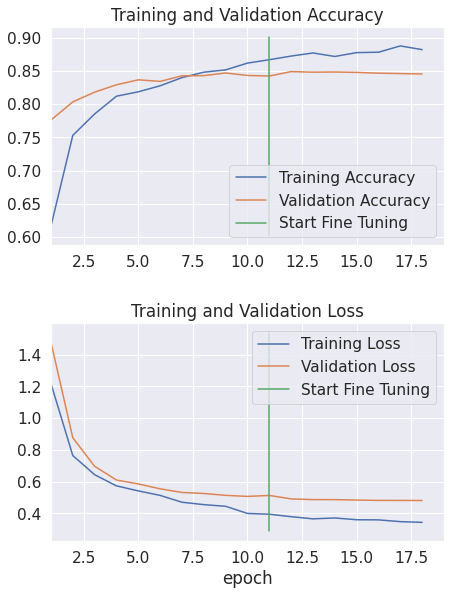

In [ ]:
acc = vgg_full_history["accuracy"]
val_acc = vgg_full_history['val_accuracy']

loss = vgg_full_history['loss']
val_loss = vgg_full_history['val_loss']

plt.figure(figsize=(7, 9))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epoch-1,initial_epoch-1],
          plt.ylim(), label='Start Fine Tuning')
plt.xlim(1,19)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epoch-1,initial_epoch-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.xlim(1,19)
plt.tight_layout(pad=2.0)
plt.show()

## **Evaluation of VGG16 Fine-Tune Model**

Note : Althought we know that fine-tuning did not improve accuracy on validation set, let us just print and see the values for once.

In [ ]:
ft_vgg16_model = load_model("Fine_Tune-MODEL_VGG-16-14-0.85.hdf5")

In [ ]:
result_3 =  model_evaluation(ft_vgg16_model, train_generator_shuffle)
true_classes_3, preds_classes_3, target_names_3 = result_3[0], result_3[1], result_3[2]

train_ft_acc = accuracy_score(true_classes_3, preds_classes_3) 
print("VGG16 Model WITH Fine-Tuning on Training set has Accuracy: {:.2f}%".format(train_ft_acc * 100))

VGG16 Model WITH Fine-Tuning on Training set has Accuracy: 90.81%


In [ ]:
result_4 =  model_evaluation(ft_vgg16_model, validate_generator_shuffle)
true_classes_4, preds_classes_4, target_names_4 = result_4[0], result_4[1], result_4[2]

validate_ft_acc = accuracy_score(true_classes_4, preds_classes_4) 
print("VGG16 Model WITH Fine-Tuning on Validation set has Accuracy: {:.2f}%".format(validate_ft_acc * 100))

VGG16 Model WITH Fine-Tuning on Validation set has Accuracy: 84.86%


In [ ]:
print("Classification report of Validation set after Fine-Tuning : ")
print(classification_report(true_classes_4, preds_classes_4,target_names =  target_names_4))

Classification report of Validation set after Fine-Tuning : 
                 precision    recall  f1-score   support

          Bread       0.85      0.73      0.79       362
  Dairy product       0.84      0.74      0.79       144
        Dessert       0.79      0.82      0.81       500
            Egg       0.71      0.85      0.77       327
     Fried food       0.83      0.84      0.84       326
           Meat       0.82      0.86      0.84       449
  Noodles-Pasta       0.99      0.96      0.97       147
           Rice       0.92      0.97      0.94        96
        Seafood       0.90      0.81      0.86       347
           Soup       0.93      0.93      0.93       500
Vegetable-Fruit       0.92      0.92      0.92       237

       accuracy                           0.85      3435
      macro avg       0.86      0.86      0.86      3435
   weighted avg       0.85      0.85      0.85      3435



Confusion Matrix of Validation set after Fine-Tuning : 


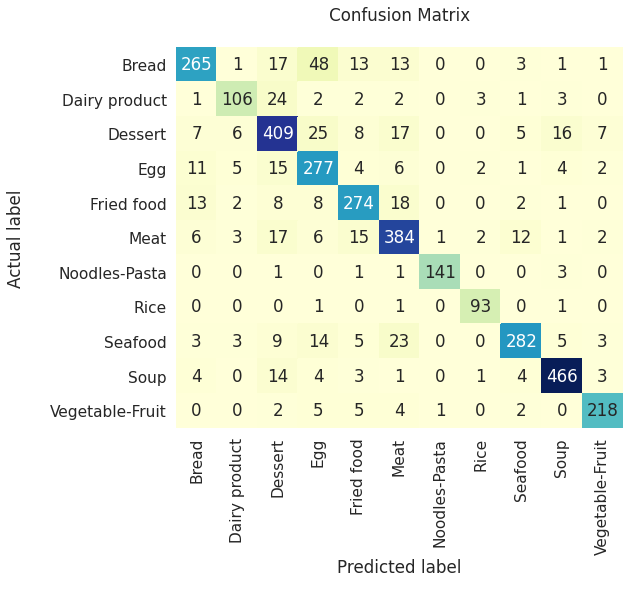

In [ ]:
print("Confusion Matrix of Validation set after Fine-Tuning : ")
plot_confusion_matrix(true_classes_4, preds_classes_4, target_names_4)

The model with out Fine-tuning on Validation set gives an accuracy of 84.80% and with Fine-tuning the accuracy is 84.86%. The difference is only 0.06%. 

But the VGG-16 model that I finalize is the VGG-16 Fine-Tuned Model.

# **Accuracy of the Best VGG-Model Model :**

In [ ]:
result_5 =  model_evaluation(ft_vgg16_model, test_generator)
true_classes_5, preds_classes_5, target_names_5 = result_5[0], result_5[1], result_5[2]

test_ft_acc = accuracy_score(true_classes_5, preds_classes_5) 
print("Inception Model WITH Fine-Tuning on Validation set has Accuracy: {:.2f}%".format(test_ft_acc * 100))

Inception Model WITH Fine-Tuning on Validation set has Accuracy: 86.13%


# **Final Model**

The Fine-Tuning Inception Model performs better than the Fine-tuned VGG-16 model in train, validate and test set. 

The difference between these two model on test set is 5.75%. (91.88% - 86.13%)

So the Inception Model is better than VGG-16 model by ~ 6%.

So let us load the final model and predict some food images

In [ ]:
ft_inception_model = load_model("INCEPTION-FT-24-0.90.hdf5") 

In [ ]:
from keras.applications import inception_v3
from keras.preprocessing import image

In [ ]:
def predict_image(pathh):
  img = image.load_img(pathh, target_size=(299, 299))
  img_array = image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)
  img_preprocessed = inception_v3.preprocess_input(img_batch)
  prediction = ft_inception_model.predict(img_preprocessed)
  return target_labels[np.argmax(prediction)]

Prediction :  Meat


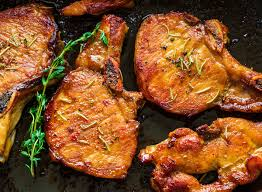

In [ ]:
file = "meat.jpg"
img = cv2.imread(file)
print("Prediction : ",predict_image(file))
cv2_imshow(img)

Prediction :  Seafood


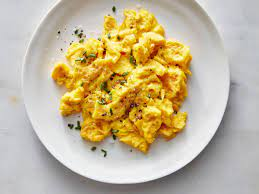

In [ ]:
file = "egg5.jpg"
img = cv2.imread(file)
print("Prediction : ",predict_image(file))
cv2_imshow(img)

Prediction :  Egg


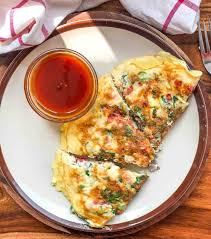

In [ ]:
file = "egg2.jpg"
img = cv2.imread(file)
print("Prediction : ",predict_image(file))
cv2_imshow(img)

Prediction :  Vegetable-Fruit


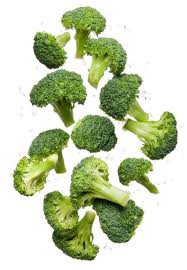

In [ ]:
file = "vegetable.jpg"
img = cv2.imread(file)
print("Prediction : ",predict_image(file))
cv2_imshow(img)